In [1]:
from dataloader import DAVIS_Seq2, normalize_image
from model import Model
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
data_set = DAVIS_Seq2(is_uniform=True, is_one_video=True)

batch_size = 10
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [3]:
pre_frame, curr_frame, pre_boundary, curr_boundary = next(iter(data_loader))

Text(0.5, 1.0, 'Curr Frame')

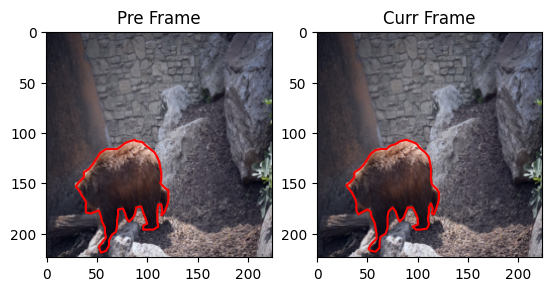

In [4]:
index = 0
plt.subplot(1, 2, 1)
plt.imshow(normalize_image(pre_frame[index].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 2, 2)
plt.imshow(normalize_image(curr_frame[index].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')


In [5]:
model = Model()

In [6]:
def chamer_distance_loss(x, y):
    def my_chamfer_distance(x, y):
        x = x.unsqueeze(1)
        y = y.unsqueeze(0)
        dist = torch.sum((x - y) ** 2, dim=-1)
        dist1 = torch.min(dist, dim=1)[0]
        dist2 = torch.min(dist, dim=0)[0]
        return torch.mean(dist1) + torch.mean(dist2)
    result = torch.tensor(0.0).to(x.device)
    for i in range(x.shape[0]):
        result += my_chamfer_distance(x[i], y[i])

    return result / x.shape[0]

In [7]:
torch.cuda.empty_cache()

In [8]:
output = model(pre_frame, curr_frame, pre_boundary)
predic_boundary = output + pre_boundary
chamer_distance_loss(predic_boundary, curr_boundary.float())

tensor(7.2131, grad_fn=<DivBackward0>)

In [9]:
model = Model().to('cuda')
data_set = DAVIS_Seq2(is_uniform=True, is_one_video=True)
model_name = "uniform_model"
# data_set = DAVIS_Seq2(is_uniform=False, is_one_video=True)
# model_name = "simplify_model"
batch_size = 5
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [14]:
torch.cuda.memory_allocated() / 1024 / 1024 / 1024

5.391773223876953

In [11]:
dict_loss = {}
num_epochs = 30
optimizer = optim.Adam(model.parameters(), lr=1e-5)
gradient_clip = 1
min_loss = 1e10
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
for e in range(num_epochs):
    for pre_frame, curr_frame, pre_boundary, curr_boundary in tqdm(data_loader):
        pre_frame, curr_frame, pre_boundary, curr_boundary = (
            pre_frame.to("cuda"),
            curr_frame.to("cuda"),
            pre_boundary.to("cuda"),
            curr_boundary.to("cuda"),
        )
        optimizer.zero_grad()
        output = model(pre_frame, curr_frame, pre_boundary)
        predic_boundary = output + pre_boundary
        loss = chamer_distance_loss(predic_boundary, curr_boundary.float())
        loss.backward()
        # nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        optimizer.step()
        if loss.item() < min_loss:
            min_loss = loss.item()
            torch.save(model.state_dict(), f"{model_name}.pth")
    dict_loss[e] = loss.item()
    scheduler.step()
    print(f"Epoch {e + 1}, Loss: {loss.item()}")

100%|█████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.33s/it]


Epoch 1, Loss: 4.538900852203369


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.14s/it]


Epoch 2, Loss: 14.991416931152344


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.14s/it]


Epoch 3, Loss: 7.11298942565918


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.14s/it]


Epoch 4, Loss: 6.079583168029785


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.14s/it]


Epoch 5, Loss: 5.5758867263793945


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.15s/it]


Epoch 6, Loss: 4.772097587585449


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:33<00:00,  1.99s/it]


Epoch 7, Loss: 4.428751468658447


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:35<00:00,  2.10s/it]


Epoch 8, Loss: 6.551541328430176


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:33<00:00,  2.00s/it]


Epoch 9, Loss: 5.050811767578125


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:48<00:00,  2.84s/it]


Epoch 10, Loss: 4.58245849609375


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:34<00:00,  2.01s/it]


Epoch 11, Loss: 4.145683288574219


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:48<00:00,  2.85s/it]


Epoch 12, Loss: 3.805642604827881


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.14s/it]


Epoch 13, Loss: 3.8337440490722656


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:34<00:00,  2.01s/it]


Epoch 14, Loss: 3.0447590351104736


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.16s/it]


Epoch 15, Loss: 3.106736421585083


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:48<00:00,  2.87s/it]


Epoch 16, Loss: 3.3036551475524902


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.15s/it]


Epoch 17, Loss: 4.663004398345947


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:34<00:00,  2.01s/it]


Epoch 18, Loss: 4.673639297485352


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:33<00:00,  2.00s/it]


Epoch 19, Loss: 2.493151903152466


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:33<00:00,  1.99s/it]


Epoch 20, Loss: 4.419417381286621


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.14s/it]


Epoch 21, Loss: 2.473679542541504


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.14s/it]


Epoch 22, Loss: 4.267784118652344


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.14s/it]


Epoch 23, Loss: 2.9540696144104004


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.14s/it]


Epoch 24, Loss: 3.5671229362487793


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:33<00:00,  2.00s/it]


Epoch 25, Loss: 2.5011701583862305


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:33<00:00,  1.99s/it]


Epoch 26, Loss: 3.456756353378296


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.14s/it]


Epoch 27, Loss: 4.196774482727051


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.15s/it]


Epoch 28, Loss: 4.815945625305176


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:33<00:00,  2.00s/it]


Epoch 29, Loss: 6.834569931030273


100%|█████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.14s/it]

Epoch 30, Loss: 3.2233781814575195


In [15]:
normalize_loss_dict = dict_loss.copy()

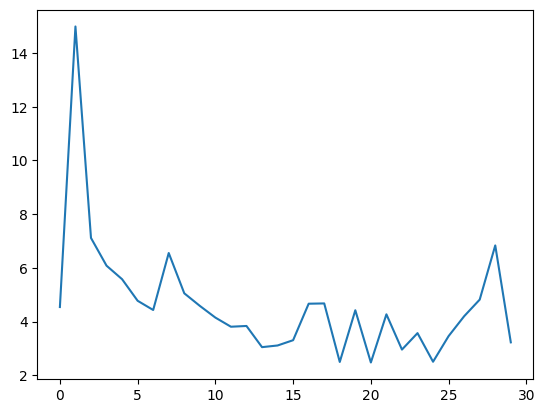

In [12]:
# plot the loss
plt.plot(list(dict_loss.keys()), list(dict_loss.values()))

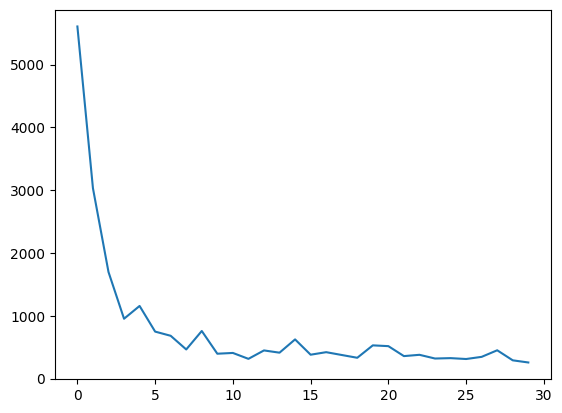

In [17]:
# plot the loss
plt.plot(list(normalize_loss_dict.keys()), list(normalize_loss_dict.values()))

In [13]:
model.load_state_dict(torch.load(f"{model_name}.pth"))

<All keys matched successfully>

In [ ]:
def test_model(model, test_dataset):
    pass
test_model(model, data_set)